# Phase 5: Time Series Analysis of Beijing Housing Data

This notebook provides a comprehensive analysis of the Beijing housing dataset, focusing on district-level characteristics and temporal trends in property transactions. Using pandas for data manipulation and Matplotlib/Seaborn for visualization, we’ll generate insightful plots to explore market dynamics over time.

## Data Loading

Load the `housing_extended.csv` dataset, which contains enriched housing data from previous phases, including transaction times and derived features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load dataset
try:
    housing_extended = pd.read_csv('housing_extended.csv', encoding='gbk')
    logger.info(f"Dataset loaded successfully. Shape: {housing_extended.shape}")
except FileNotFoundError:
    logger.error("File 'housing_extended.csv' not found.")
    raise

# Convert tradeTime to datetime
housing_extended['tradeTime'] = pd.to_datetime(housing_extended['tradeTime'], errors='coerce')
logger.info("Converted 'tradeTime' to datetime format.")

housing_extended.head()

2025-04-10 00:03:44,016 - INFO - Dataset loaded successfully. Shape: (285040, 20)
2025-04-10 00:03:44,063 - INFO - Converted 'tradeTime' to datetime format.


,Lng,Lat,tradeTime,DOM,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,subway,district,distanceToCapital,pricePerSquare
0,116.475489,40.019520,2016-08-09,1464.0,415.0,131.00,2,1,1,1,26,2005,Simplicity,steel-concrete composite,0.217,has elevator,has subway,7,14.074996,3167.938931
1,116.453917,39.881534,2016-07-28,903.0,575.0,132.38,2,2,1,2,22,2004,hardcover,steel-concrete composite,0.667,has elevator,no subway,7,4.701224,4343.556428
2,116.438010,40.076114,2016-09-30,965.0,297.5,134.00,3,1,1,1,21,2008,other,steel-concrete composite,0.273,has elevator,no subway,6,19.293041,2220.149254
3,116.428392,39.886229,2016-08-28,927.0,392.0,81.00,2,1,1,1,6,1960,rough,mixed,0.333,no elevator,has subway,1,2.683335,4839.506173
4,116.466280,39.991363,2016-07-22,861.0,275.6,53.00,1,0,1,1,8,2005,Simplicity,steel-concrete composite,0.333,has elevator,no subway,7,10.914652,5200.000000


## Part 1: District-Level Summary

Create a DataFrame `districts_df` summarizing key metrics for each of the 13 districts, indexed by `district`. This includes average price per square meter, percentage of houses with elevators and subway access, average house size, building age (relative to 2021), and the most frequent building structure.

In [2]:
# Initialize districts_df
districts_df = pd.DataFrame({'district': np.sort(housing_extended['district'].unique())})
districts_df.set_index('district', inplace=True)

# Calculate metrics
districts_df['pricePerSquare mean'] = housing_extended.groupby('district')['pricePerSquare'].mean()
districts_df['% houses with elevator'] = housing_extended.groupby('district')['elevator'].apply(
    lambda x: (x[x == 'has elevator'].count() / x.count()) * 100
)
districts_df['% houses with subway'] = housing_extended.groupby('district')['subway'].apply(
    lambda x: (x[x == 'has subway'].count() / x.count()) * 100
)
districts_df['square mean'] = housing_extended.groupby('district')['square'].mean()
districts_df['building age mean'] = 2021 - housing_extended.groupby('district')['constructionTime'].mean()
districts_df['frequent buildingStructure'] = housing_extended.groupby('district')['buildingStructure'].agg(
    lambda x: x.value_counts().idxmax()
)

logger.info("District summary DataFrame created.")
districts_df

2025-04-10 00:05:34,377 - INFO - District summary DataFrame created.


,pricePerSquare mean,% houses with elevator,% houses with subway,square mean,building age mean,frequent buildingStructure
district,,,,,,
1,5981.774965,56.216550,93.488404,67.047856,25.151709,steel-concrete composite
2,3805.924811,68.647623,61.825544,76.951352,20.639123,steel-concrete composite
3,3130.333142,66.636691,47.032374,92.071484,15.494604,steel-concrete composite
4,2999.928821,39.983398,43.027117,86.322272,18.324364,mixed
5,2841.761483,80.077031,39.005602,89.297990,11.271359,steel-concrete composite
6,2952.222451,37.892663,43.553669,100.121614,17.536464,mixed
7,4225.965657,66.746216,68.307898,78.845544,22.553717,steel-concrete composite
8,5312.914827,51.883462,61.087404,73.615248,24.191570,steel-concrete composite
9,3491.126972,46.534461,27.636823,73.047513,25.653835,steel-concrete composite


## Part 2: Time Series Analysis

Perform two time series analyses using the `tradeTime` column:
1. **Central City Trade Frequency**: Plot the number of transactions within 15 km of the capital over time.
2. **Price Trend**: Visualize the average `pricePerSquare` over time.
3. **District-wise Trade Volume**: Show transaction volume per district as a stacked area plot.

2025-04-10 00:05:42,174 - INFO - Filtered data from 2010 onwards. Shape: (285035, 20)
C:\Users\MSI\AppData\Local\Temp\ipykernel_17980\64825948.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  central_trades = time_data.resample('3M', on='tradeTime')['distanceToCapital'].apply(


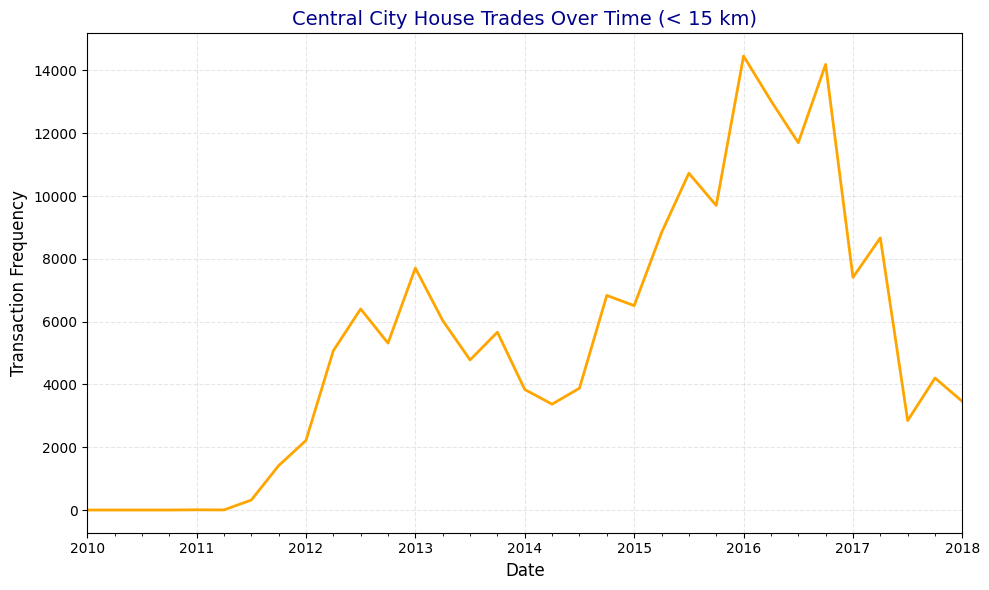

In [3]:
# Filter data from 2010 onwards
time_data = housing_extended[housing_extended['tradeTime'] >= '2010'].copy()
logger.info(f"Filtered data from 2010 onwards. Shape: {time_data.shape}")

# Plot 1: Central City Trade Frequency
fig1, ax1 = plt.subplots(figsize=(10, 6))
central_trades = time_data.resample('3M', on='tradeTime')['distanceToCapital'].apply(
    lambda x: x[x < 15].count()
)
central_trades.plot(ax=ax1, color='orange', linewidth=2)
ax1.set_title('Central City House Trades Over Time (< 15 km)', fontsize=14, color='darkblue')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Transaction Frequency', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

C:\Users\MSI\AppData\Local\Temp\ipykernel_17980\2485506390.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_trend = time_data.resample('3M', on='tradeTime')['pricePerSquare'].mean()


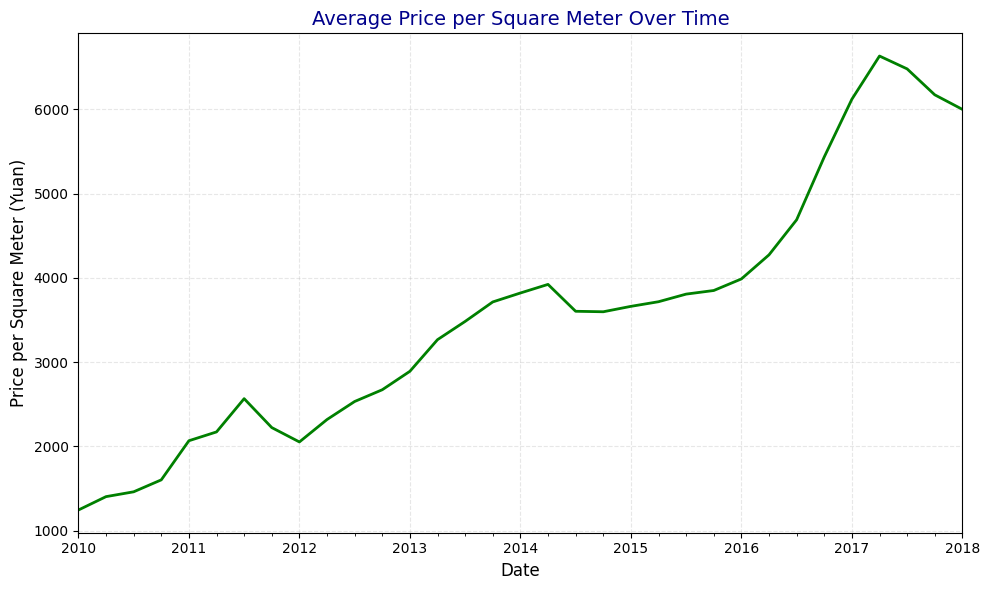

In [4]:
# Plot 2: Price Trend Over Time
fig2, ax2 = plt.subplots(figsize=(10, 6))
price_trend = time_data.resample('3M', on='tradeTime')['pricePerSquare'].mean()
price_trend.plot(ax=ax2, color='green', linewidth=2)
ax2.set_title('Average Price per Square Meter Over Time', fontsize=14, color='darkblue')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Price per Square Meter (Yuan)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

## Submission Preparation

Save the DataFrame, figures, and notebook into `result.zip` for submission.

In [ ]:
import zipfile
import joblib

# Save outputs
districts_df.to_csv('districts_df.csv', index=True)
joblib.dump(fig1, 'fig1_central_trades')
joblib.dump(fig2, 'fig2_price_trend')
joblib.dump(fig3, 'fig3_district_volume')

# Compress files
file_names = ['districts_df.csv', 'fig1_central_trades', 'fig2_price_trend', 'fig3_district_volume', '5_time_series.ipynb']
with zipfile.ZipFile('result.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for file in file_names:
        zf.write(file)
logger.info("Submission files compressed into 'result.zip'")